In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [2]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [ ]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)


# GRADED FUNCTION: create_train_test_dirs
def create_train_test_dirs(root_path):
    ### START CODE HERE

    # HINT:
    # Use os.makedirs to create your directories with intermediate subdirectories
    # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter
    os.makedirs(os.path.join(root_path, 'training/cats'))
    os.makedirs(os.path.join(root_path, 'training/dogs'))
    os.makedirs(os.path.join(root_path, 'testing/cats'))
    os.makedirs(os.path.join(root_path, 'testing/dogs'))

    ### END CODE HERE


try:
    create_train_test_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [4]:
# Test your create_train_test_dirs function
# root_dir = 'cats-v-dogs'
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

cats-v-dogs\testing
cats-v-dogs\training
cats-v-dogs\testing\cats
cats-v-dogs\testing\dogs
cats-v-dogs\training\cats
cats-v-dogs\training\dogs


In [5]:
# GRADED FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    ### START CODE HERE
    list_files = os.listdir(SOURCE)
    list_files = random.sample(list_files, len(list_files))
    list_files_filtered = []
    for file_name in list_files:
        file_path = os.path.join(SOURCE, file_name)
        if not os.path.getsize(file_path):
            print(f"{file_name} is zero length, so ignoring.")
        else:
            list_files_filtered.append(file_name)

    SPLIT_INDEX = int(len(list_files_filtered) * SPLIT_SIZE)

    # training copy
    for file_name in list_files_filtered[:SPLIT_INDEX]:
        file_path = os.path.join(SOURCE, file_name)
        copyfile(file_path, os.path.join(TRAINING, file_name))

    #   testing copy
    for file_name in list_files_filtered[SPLIT_INDEX:]:
        copyfile(file_path, os.path.join(TESTING, file_name))

    ### END CODE HERE

In [6]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

CAT_SOURCE_DIR = "PetImages/Cat/"
DOG_SOURCE_DIR = "PetImages/Dog/"

TRAINING_DIR = "cats-v-dogs/training/"
TESTING_DIR = "cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
    for file in os.scandir(TESTING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
    for file in os.scandir(TESTING_DOGS_DIR):
        os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise use a `target_size` of (150, 150)**.

**Note:** So far, you have seen the term `testing` being used a lot for referring to a subset of images within the dataset. In this exercise, all of the `testing` data is actually being used as `validation` data. This is not very important within the context of the task at hand but it is worth mentioning to avoid confusion.

In [7]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1 / 255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=64,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1 / 255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=64,
                                                                  class_mode='binary',
                                                                  target_size=(150, 150))
    ### END CODE HERE
    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
# GRADED FUNCTION: create_model
def create_model():
    # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
    # USE AT LEAST 3 CONVOLUTION LAYERS

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    from tensorflow.keras.optimizers import RMSprop

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [12]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
225/352 [==================>...........] - ETA: 52s - loss: 0.6822 - accuracy: 0.5816

C:\Users\Andrew\anaconda3\envs\TF_Developer_Certificate\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


352/352 [==============================] - 155s 426ms/step - loss: 0.6593 - accuracy: 0.6080 - val_loss: 0.3917 - val_accuracy: 1.0000
Epoch 2/15
352/352 [==============================] - 94s 268ms/step - loss: 0.5892 - accuracy: 0.6828 - val_loss: 0.2542 - val_accuracy: 1.0000
Epoch 3/15
352/352 [==============================] - 90s 255ms/step - loss: 0.5632 - accuracy: 0.7051 - val_loss: 0.3378 - val_accuracy: 1.0000
Epoch 4/15
352/352 [==============================] - 90s 255ms/step - loss: 0.5377 - accuracy: 0.7296 - val_loss: 0.1713 - val_accuracy: 1.0000
Epoch 5/15
352/352 [==============================] - 90s 255ms/step - loss: 0.5264 - accuracy: 0.7383 - val_loss: 0.2161 - val_accuracy: 1.0000
Epoch 6/15
352/352 [==============================] - 87s 248ms/step - loss: 0.5083 - accuracy: 0.7512 - val_loss: 0.1503 - val_accuracy: 1.0000
Epoch 7/15
352/352 [==============================] - 87s 246ms/step - loss: 0.4961 - accuracy: 0.7597 - val_loss: 0.0829 - val_accuracy: 1.

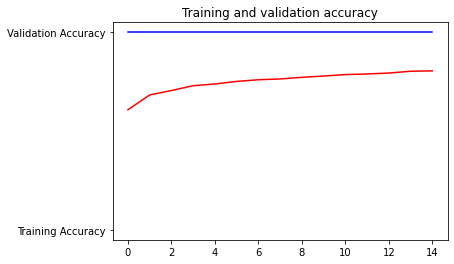

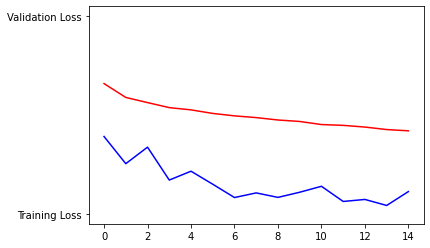

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [14]:
import pickle
with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)